In [1]:
# Import Libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from pathlib import Path

In [2]:
import kagglehub
# confusion matrix
from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers, models

In [3]:
# Download latest version
path = kagglehub.dataset_download("msambare/fer2013")

print("Path to dataset files:", path)

100%|██████████| 60.3M/60.3M [00:05<00:00, 12.0MB/s]

Extracting files...


Path to dataset files: /Users/macos/.cache/kagglehub/datasets/msambare/fer2013/versions/1


In [5]:
# Set Parameters
IMG_SIZE = 48  # Width and height
BATCH_SIZE = 64
SEED = 42
DATA_DIR = path

# Emotion categories will be inferred automatically from folder names

In [6]:
# Load training dataset with validation split (before normalization)
raw_train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=os.path.join(DATA_DIR, "train"),
    labels='inferred',
    label_mode='int',  # integer labels
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True,
    seed=SEED,
    validation_split=0.2,
    subset='training'
)

raw_val_ds = tf.keras.utils.image_dataset_from_directory(
    directory=os.path.join(DATA_DIR, "train"),
    labels='inferred',
    label_mode='int',
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True,
    seed=SEED,
    validation_split=0.2,
    subset='validation'
)

# 4️⃣ Load test dataset (no validation split)
raw_test_ds = tf.keras.utils.image_dataset_from_directory(
    directory=os.path.join(DATA_DIR, "test"),
    labels='inferred',
    label_mode='int',
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=False
)

Found 28709 files belonging to 7 classes.
Using 22968 files for training.
Found 28709 files belonging to 7 classes.
Using 5741 files for validation.
Found 7178 files belonging to 7 classes.


In [7]:
# Get class names before mapping (IMPORTANT)
class_names = raw_train_ds.class_names
class_indices = dict(zip(class_names, range(len(class_names))))
print("Emotion Label Mapping:", class_indices)

Emotion Label Mapping: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Use this only during model training
cnn_augmentation = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

In [9]:
# CNN Architecture
cnn_model = models.Sequential([
    layers.Input(shape=(48, 48, 1)),  # Grayscale image input

    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),

    layers.Dense(7, activation='softmax')  # 7 emotion classes
])

# Compile the Model
cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [10]:
# Normalize datasets using Rescaling
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = raw_train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = raw_val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = raw_test_ds.map(lambda x, y: (normalization_layer(x), y))

# Convert to NumPy arrays (for use with traditional ML models)
def convert_to_numpy(dataset):
    images = []
    labels = []
    for batch_images, batch_labels in dataset:
        images.append(batch_images.numpy())
        labels.append(batch_labels.numpy())
    return np.concatenate(images), np.concatenate(labels)

X_train_np, y_train_np = convert_to_numpy(train_ds)
X_val_np, y_val_np = convert_to_numpy(val_ds)
X_test_np, y_test_np = convert_to_numpy(test_ds)

print("Train shape:", X_train_np.shape)
print("Validation shape:", X_val_np.shape)
print("Test shape:", X_test_np.shape)

# One-hot encode labels for deep learning models
y_train_oh = to_categorical(y_train_np, num_classes=7)
y_val_oh = to_categorical(y_val_np, num_classes=7)
y_test_oh = to_categorical(y_test_np, num_classes=7)

Train shape: (22968, 48, 48, 1)
Validation shape: (5741, 48, 48, 1)
Test shape: (7178, 48, 48, 1)


In [11]:
# Train the CNN
history_cnn = cnn_model.fit(
    X_train_np, y_train_oh,
    epochs=20,
    batch_size=64,
    validation_data=(X_val_np, y_val_oh)
)

Epoch 1/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 23s 60ms/step - accuracy: 0.2549 - loss: 2.0990 - val_accuracy: 0.3026 - val_loss: 1.8119
Epoch 2/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 22s 61ms/step - accuracy: 0.3685 - loss: 1.5984 - val_accuracy: 0.3740 - val_loss: 1.5914
Epoch 3/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 22s 62ms/step - accuracy: 0.4137 - loss: 1.4744 - val_accuracy: 0.4376 - val_loss: 1.4458
Epoch 4/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 22s 62ms/step - accuracy: 0.4414 - loss: 1.4112 - val_accuracy: 0.4654 - val_loss: 1.3964
Epoch 5/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 22s 63ms/step - accuracy: 0.4654 - loss: 1.3518 - val_accuracy: 0.4686 - val_loss: 1.3777
Epoch 6/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 23s 65ms/step - accuracy: 0.4919 - loss: 1.2841 - val_accuracy: 0.5102 - val_loss: 1.3049
Epoch 7/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - accuracy: 0.5218 - loss: 1.2376 - val_accuracy: 0.4990 - val_loss: 1.3175
Epoch 8/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.5420 - loss: 1.1821 - 

In [15]:
cnn_model.save("fer2013_cnn_model_01.h5")

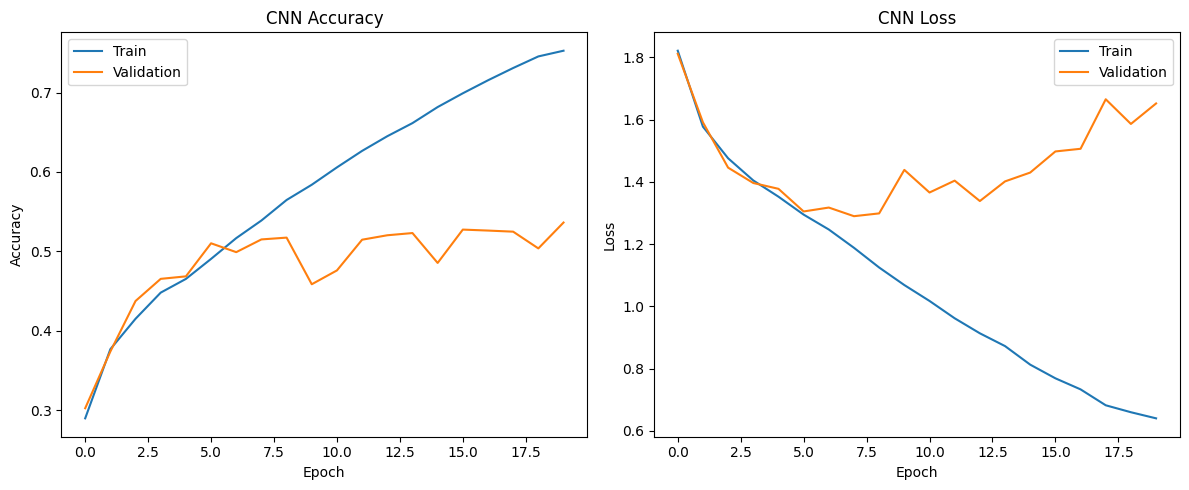

In [16]:
# Plot Training and Validation Curves
def plot_history(history, title="Model"):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(f'{title} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history_cnn, title="CNN")

In [12]:
# Evaluate the Model
# Predict class probabilities
y_pred_probs = cnn_model.predict(X_test_np)
y_pred_cnn = y_pred_probs.argmax(axis=1)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Accuracy
print("Test Accuracy:", accuracy_score(y_test_np, y_pred_cnn))

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_test_np, y_pred_cnn, target_names=class_names, zero_division=0))

225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
Test Accuracy: 0.5536361103371412

Classification Report:

              precision    recall  f1-score   support

       angry       0.43      0.45      0.44       958
     disgust       1.00      0.11      0.20       111
        fear       0.39      0.44      0.41      1024
       happy       0.79      0.78      0.78      1774
     neutral       0.53      0.48      0.50      1233
         sad       0.40      0.46      0.43      1247
    surprise       0.76      0.65      0.70       831

    accuracy                           0.55      7178
   macro avg       0.61      0.48      0.49      7178
weighted avg       0.57      0.55      0.56      7178



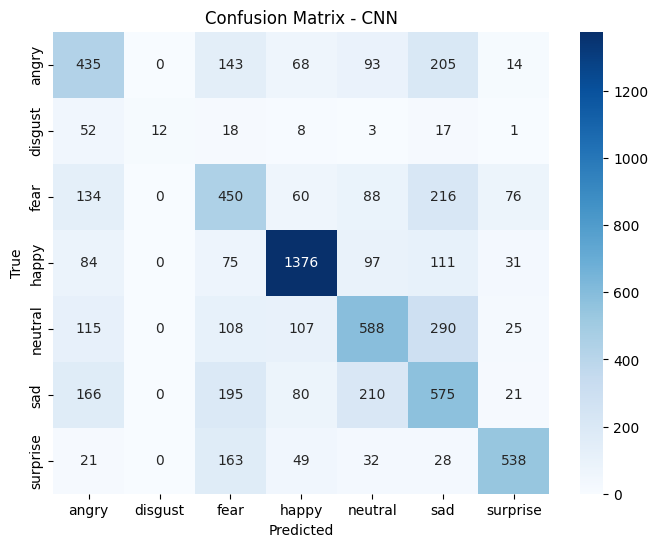

In [13]:
# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test_np, y_pred_cnn), annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - CNN")
plt.show()

Epoch 1/20
717/717 ━━━━━━━━━━━━━━━━━━━━ 30s 42ms/step - accuracy: 0.4964 - loss: 1.3215 - val_accuracy: 0.5360 - val_loss: 1.2062
Epoch 2/20
  1/717 ━━━━━━━━━━━━━━━━━━━━ 28s 40ms/step - accuracy: 0.5625 - loss: 1.5361

/Users/macos/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5625 - loss: 1.5361 - val_accuracy: 0.5363 - val_loss: 1.2053
Epoch 3/20
717/717 ━━━━━━━━━━━━━━━━━━━━ 30s 42ms/step - accuracy: 0.5144 - loss: 1.2887 - val_accuracy: 0.5259 - val_loss: 1.2627
Epoch 4/20
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5312 - loss: 1.3050 - val_accuracy: 0.5299 - val_loss: 1.2598
Epoch 5/20
717/717 ━━━━━━━━━━━━━━━━━━━━ 30s 41ms/step - accuracy: 0.5147 - loss: 1.2944 - val_accuracy: 0.5544 - val_loss: 1.1866
Epoch 6/20
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3750 - loss: 1.4543 - val_accuracy: 0.5550 - val_loss: 1.1906
Epoch 7/20
717/717 ━━━━━━━━━━━━━━━━━━━━ 30s 42ms/step - accuracy: 0.5310 - loss: 1.2564 - val_accuracy: 0.5658 - val_loss: 1.1631
Epoch 8/20
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4688 - loss: 1.2211 - val_accuracy: 0.5642 - val_loss: 1.1639
Epoch 9/20
717/717 ━━━━━━━━━━━━━━━━━━━━ 30s 41ms/step - accuracy: 0.5270 - loss: 1.2676 - val_accuracy: 0.541

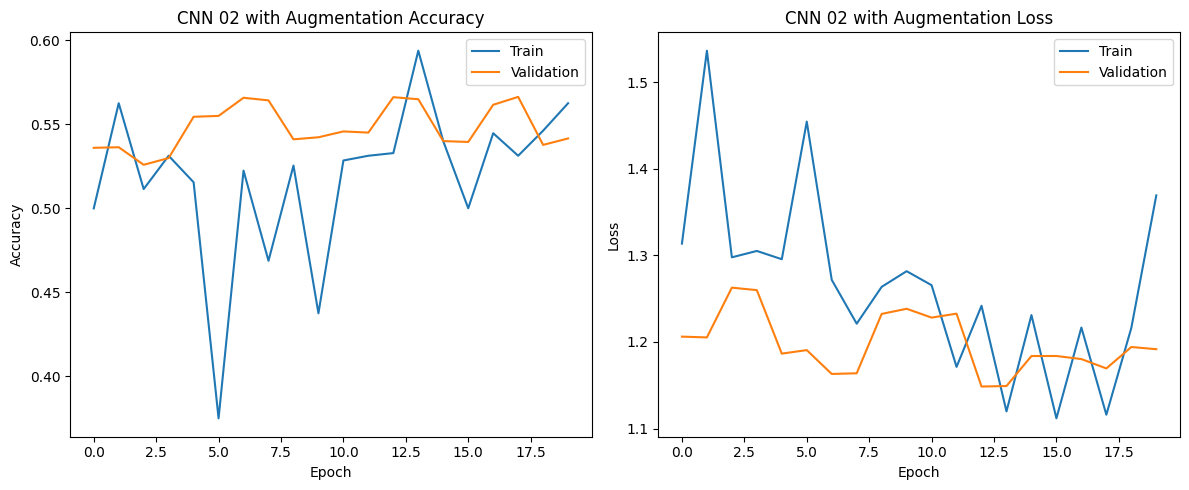

225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
Test Accuracy: 0.5533574811925327


In [19]:
# Fit the generator to your training data
cnn_augmentation.fit(X_train_np)

# Use in model training
history_cnn02 = cnn_model.fit(
    cnn_augmentation.flow(X_train_np, y_train_oh, batch_size=32),
    steps_per_epoch=len(X_train_np) // 32,
    epochs=20,
    validation_data=(X_val_np, y_val_oh)
)

cnn_model.save("fer2013_cnn_model_02.h5")

plot_history(history_cnn02, title="CNN 02 with Augmentation")

y_pred_probs = cnn_model.predict(X_test_np)
y_pred_cnn = y_pred_probs.argmax(axis=1)

# Accuracy
print("Test Accuracy:", accuracy_score(y_test_np, y_pred_cnn))

Epoch 1/20
  3/717 ━━━━━━━━━━━━━━━━━━━━ 29s 41ms/step - accuracy: 0.6302 - loss: 1.0971

/Users/macos/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


717/717 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - accuracy: 0.5524 - loss: 1.2051 - val_accuracy: 0.5724 - val_loss: 1.1321
Epoch 2/20
  1/717 ━━━━━━━━━━━━━━━━━━━━ 26s 36ms/step - accuracy: 0.5000 - loss: 1.1620

/Users/macos/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5000 - loss: 1.1620 - val_accuracy: 0.5710 - val_loss: 1.1314
Epoch 3/20
717/717 ━━━━━━━━━━━━━━━━━━━━ 31s 43ms/step - accuracy: 0.5443 - loss: 1.2113 - val_accuracy: 0.4072 - val_loss: 1.9330
Epoch 4/20
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5000 - loss: 1.1819 - val_accuracy: 0.3991 - val_loss: 2.0290
Epoch 5/20
717/717 ━━━━━━━━━━━━━━━━━━━━ 31s 43ms/step - accuracy: 0.5479 - loss: 1.2008 - val_accuracy: 0.5570 - val_loss: 1.1652
Epoch 6/20
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7188 - loss: 0.8738 - val_accuracy: 0.5522 - val_loss: 1.1707
Epoch 7/20
717/717 ━━━━━━━━━━━━━━━━━━━━ 30s 41ms/step - accuracy: 0.5487 - loss: 1.2064 - val_accuracy: 0.5018 - val_loss: 1.2927
Epoch 8/20
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6562 - loss: 1.0187 - val_accuracy: 0.5020 - val_loss: 1.2994
Epoch 9/20
717/717 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.5649 - loss: 1.1720 - val_accuracy: 0.532

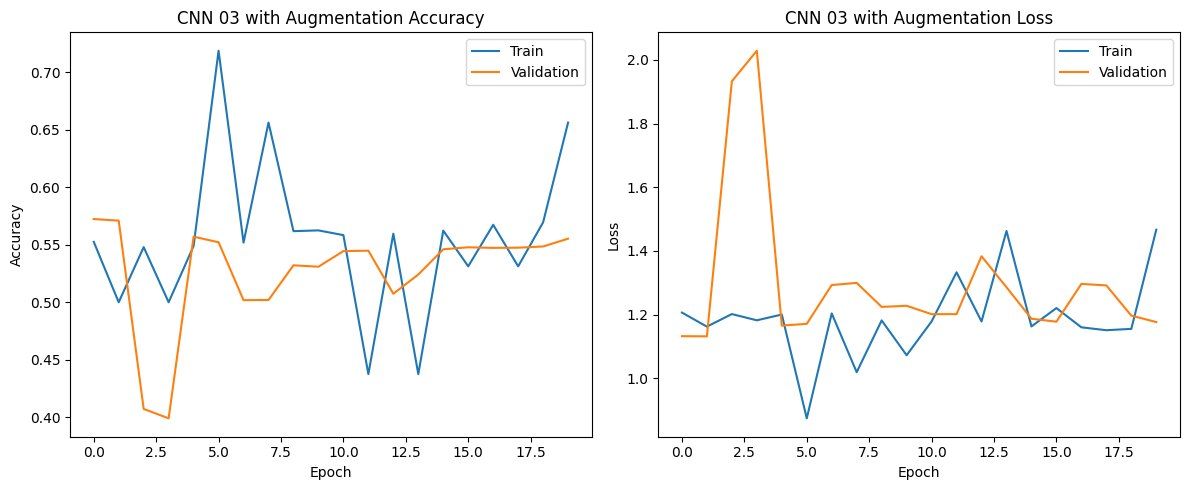

225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
Test Accuracy: 0.56143772638618


In [20]:
# continue train 20 epochs with augmentation
# Use in model training
history_cnn03 = cnn_model.fit(
    cnn_augmentation.flow(X_train_np, y_train_oh, batch_size=32),
    steps_per_epoch=len(X_train_np) // 32,
    epochs=20,
    validation_data=(X_val_np, y_val_oh)
)

cnn_model.save("fer2013_cnn_model_03.h5")

plot_history(history_cnn03, title="CNN 03 with Augmentation")

y_pred_probs = cnn_model.predict(X_test_np)
y_pred_cnn = y_pred_probs.argmax(axis=1)

# Accuracy
print("Test Accuracy:", accuracy_score(y_test_np, y_pred_cnn))